In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
# MNIST 데이터를 읽고 신경망에 입력할 준비
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))
zdim=32 # 잠복 공간의 차원

# 오토인코더의 인코더 부분 설계
encoder_input=Input(shape=(28,28,1))
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Flatten()(x)
encoder_output=Dense(zdim)(x)
model_encoder=Model(encoder_input,encoder_output)
# 오토인코더의 디코더 부분 설계
decoder_input=Input(shape=(zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='relu',padding='same',strides=(1,1))(x)
decoder_output=x
model_decoder=Model(decoder_input,decoder_output)
# 인코더와 디코더를 결합하여 오토인코더 모델 구축
model_input=encoder_input
model_output=model_decoder(encoder_output)
model=Model(model_input,model_output)

# 오토인코더 학습
# 노트북으로 인해 높은 배치사이즈와 1에포크 설정
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=1,batch_size=1024,shuffle=True,validation_data=(x_test,x_test))

59/59 [==============================] - 76s 1s/step - loss: 0.0659 - val_loss: 0.0453


313/313 [==============================] - 11s 31ms/step


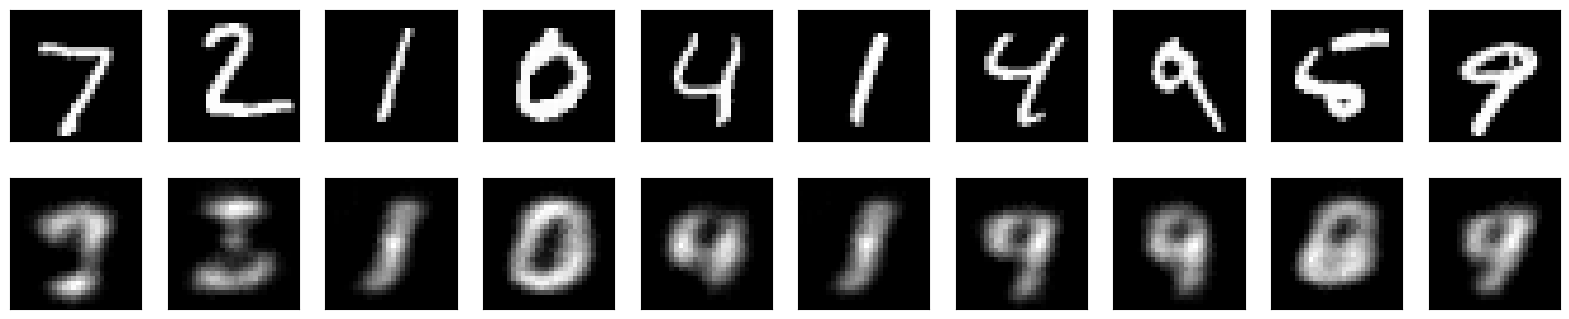

In [3]:
# 복원 실험 1: x_test를 복원하는 예측 실험
decoded_img=model.predict(x_test)
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_img[i].reshape(28, 28),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

1/1 [==============================] - 0s 451ms/step


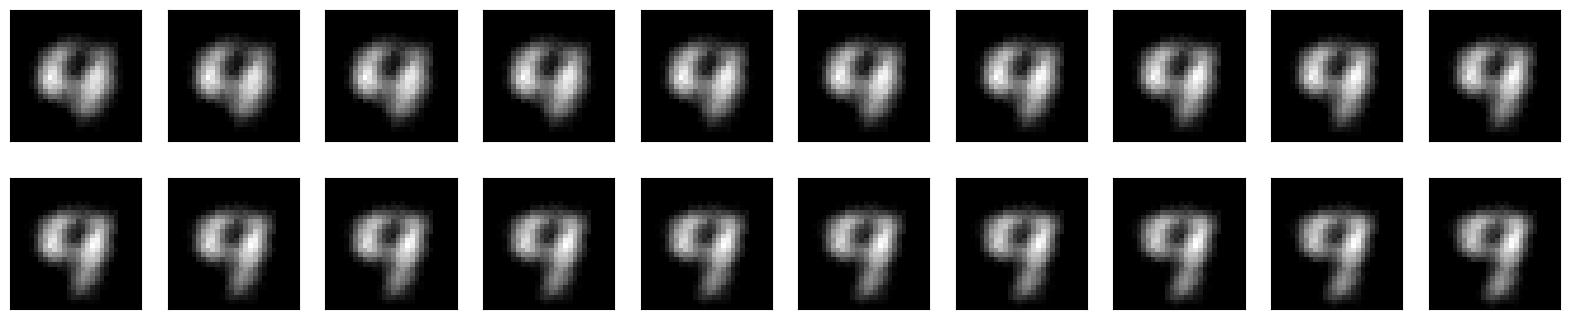

In [4]:
# 생성 실험 2: 같은 부류의 두 샘플 사이를 보간하여 새로운 샘플 생성
x4_6=np.array((x_test[4],x_test[6]))
z=model_encoder.predict(x4_6)
zz=np.zeros((20,zdim))
for i in range(20):
    alpha=i/(20.0-1.0)
    zz[i]=(1.0-alpha)*z[0]+alpha*z[1]
generated_img=model_decoder.predict(zz)

plt.figure(figsize=(20, 4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()